In [1]:
import comp_viz
networks = comp_viz.utils.ObjectDetection.get_networks()
print(networks)

['yolo3_mobilenet1.0_coco', 'ssd_512_resnet50_v1_coco', 'yolo3_darknet53_coco', 'center_net_resnet101_v1b_dcnv2_coco', 'faster_rcnn_fpn_resnet50_v1b_coco', 'faster_rcnn_fpn_syncbn_resnest269_coco']


In [2]:
dataset = { 'person': {"images": 'datasets/person_0/images/', "labels": "datasets/person_0/labelTxt/"} }

In [4]:
import os
for network in networks:
  try:
    os.mkdir(f"tests/{network}")
  except:
    print("Directory exists")

for network in networks:
  try:
    os.mkdir(f"inference/{network}")
  except:
    print("Directory exists")

Directory exists
Directory exists
Directory exists
Directory exists
Directory exists
Directory exists


In [ ]:
import numpy as np
for network in networks:
  model = comp_viz.object_detection.Model(network)
  model.set_classes(["person"])
  time = 0
  for image_fname in os.listdir(dataset["person"]["images"]):
    time += model.get_prediction(os.path.join(dataset["person"]["images"],image_fname),nms=.5)["time"]
  throughput = time / len(os.listdir(dataset["person"]["images"]))
  with open(f"tests/{network}/results.txt", "w") as f:
    f.write(f"Images/Sec: {np.round(throughput, 4)}")

In [3]:
import json
import pathlib
network = networks[0]
model = comp_viz.object_detection.Model(network)
model.set_classes(['person'])
for image_fname in os.listdir(dataset["person"]["images"]):
  pred = model.get_prediction(os.path.join(dataset["person"]["images"],image_fname),nms=.5)
  with open(f"inference/{network}/{pathlib.Path(image_fname).stem}.txt", "w") as f:
    f.write(json.dumps(pred,indent=2))


Model successfully initialized.
gpu(0)
Complete. Model set to detect for object classes: ['person'].


In [5]:
import gluoncv
tracker = gluoncv.utils.metrics.VOCMApMetric(iou_thresh=.5,class_names=["person"])

In [38]:
import json
import numpy as np

def get_gt(fname):
  with open(fname, "r") as f:
    datas = []
    for line in f:
      datas.append(line.strip().split(" "))
  bboxes = []
  labels = []
  for data in datas:
    bboxes.append( [float(data[0]),
                    float(data[1]),
                    float(data[2]),
                    float(data[5])] )
    labels.append(int(data[9]))
  return np.array(bboxes), np.array(labels)


def get_inf(fname):
  with open(fname) as f:
    pred = json.load(f)
  return np.array(pred["bounding_boxes"]), np.array(pred["class_ids"]), np.array([pred["confidence_scores"]])

gt = "datasets/person_0/labelTxt/271.txt"
inf = "inference/yolo3_mobilenet1.0_coco/279.txt"

inf_bb, inf_labels, inf_scores = get_inf(inf)
gt_bb, gt_labels = get_gt(gt)

print(inf_bb, inf_labels, inf_scores)
print(gt_bb, gt_labels)




[[  3.  23. 408. 395.]] [0] [[0.563]]
[[271.  99. 416. 377.]] [0]


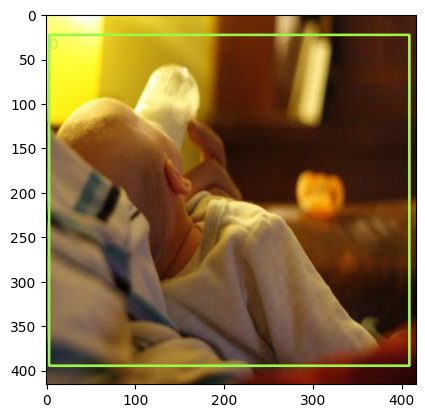

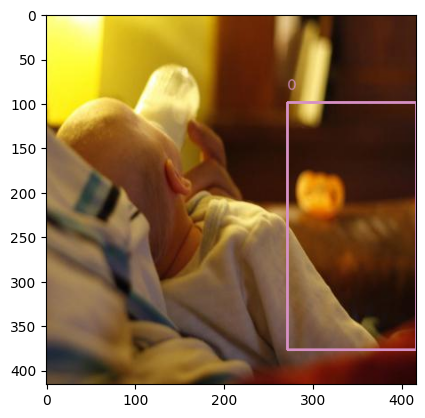

In [39]:
import comp_viz
import gluoncv
import numpy as np


img_path = "datasets/person_0/images/279.jpg"

img = comp_viz.utils.Tools.get_cv2_image(img_path)
thing1 = gluoncv.utils.viz.cv_plot_bbox(img, inf_bb, labels=inf_labels )
comp_viz.utils.Tools.show_image(thing1)

img = comp_viz.utils.Tools.get_cv2_image(img_path)
thing2 = gluoncv.utils.viz.cv_plot_bbox(img, gt_bb, labels=gt_labels )
comp_viz.utils.Tools.show_image(thing2)

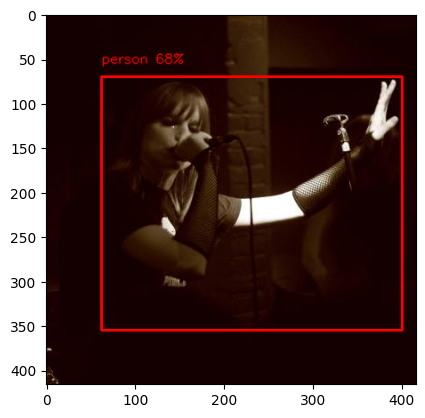

In [30]:
import comp_viz
img = "datasets/person_0/images/30.jpg"
comp_viz.utils.ObjectDetection.show_pred_bboxes_image(img,[[62., 70., 330. + 70.,355.]],[0],["person"],[.689])